# Install Libraries if Needed (Only Run Once)

In [1]:
!pip install -U deepxde
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install -U tensorflow
!pip install -U "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html  # Note: wheels only available on linux.
!pip install ipympl


Defaulting to user installation because normal site-packages is not writeable
  Using cached DeepXDE-0.13.6-py3-none-any.whl (112 kB)
  Using cached scikit_optimize-0.9.0-py2.py3-none-any.whl (100 kB)
  Using cached pyaml-21.10.1-py2.py3-none-any.whl (24 kB)
You should consider upgrading via the '/opt/miniconda3/envs/opence-v1.3.1/bin/python -m pip install --upgrade pip' command.


# Import Libraries

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import re

import matplotlib.pyplot as plt
import numpy as np

import deepxde as dde
from deepxde.backend import tf

from mpl_toolkits.mplot3d import Axes3D
import sys
from scipy.integrate import odeint


Using backend: tensorflow.compat.v1

2021-11-16 14:56:55.075539: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
non-resource variables are not supported in the long term



# Lorentz System
$$
x_t = C_1(y-x)\\
y_t = x(C_2-z) - y\\
z_t = x y - C_3 z\\
t\in[0,t_{end}]
$$

# Generate Training Data

In [3]:
def gen_training_data(C1=10.0, C2=20.0, C3=8.0/3.0, x0=5, y0=8, z0=2, tend=3, dt=0.01, tskip=1):
    # C1 = 10.0
    # C2 = 20.0 #28.0
    # C3 = 8.0 / 3.0
    # x0 = 5
    # y0 = 8
    # z0 = 2
    # tend = 3

    def f(state, t):
        x, y, z = state  # Unpack the state vector
        return [C1 * (y - x),
                x * (C2 - z) - y, 
                x * y - C3 * z]  # Derivatives

    state0 = [x0, y0, z0]
    t = np.arange(0.0, tend, dt)
    states = odeint(f, state0, t)
    t = np.reshape(t,(-1,1))
    return t[::tskip], states[::tskip], state0, tend

def plot_states(t, states):
    # plt.close('all')s
    plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot3D(states[:, 0], states[:, 1], states[:, 2])
    plt.xlabel('x')
    plt.ylabel('y')
    ax.set_zlabel('z')
    

    plt.figure()
    plt.plot(t[:,0],states[:,0],'b-',label='x')
    plt.plot(t[:,0],states[:,1],'r-',label='y')
    plt.plot(t[:,0],states[:,2],'y-',label='z')
    plt.xlabel('time')
    plt.ylabel('position')
    plt.title('Lorentz System: Position vs Time')
    plt.legend()
    plt.show()


## Data Generation Tips:
Feel free to play around with the parameters, but there are failure cases where the PINN will not converge.  Note that this system is known to be chaotic near C1=10, C2=28, C3=8/3.  PINN is better at shorter time scales.

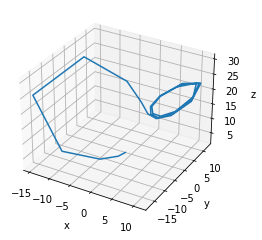

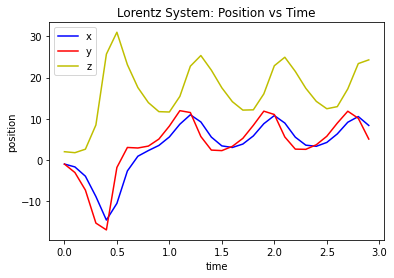

In [24]:
C1true = 10.0
C2true = 20
C3true = 8.0/3.0
x0=-1
y0=-1
z0=2
tend=3
dt=0.01
tskip=10
observe_t, ob_y, y0, tend = gen_training_data(C1=C1true, C2=C2true, C3=C3true, x0=x0, y0=y0, z0=z0, tend=tend, dt=dt, tskip=tskip)
plot_states(observe_t, ob_y)

# Declare Variable Coefficients

In [25]:

# parameters to be identified
C1 = tf.Variable(1.0)
C2 = tf.Variable(1.0)
C3 = tf.Variable(1.0)


# Define the Governing PDE

In [26]:

# define system ODEs
def Lorenz_system(x, y):
    """Lorenz system.
    dy1/dx = 10 * (y2 - y1)
    dy2/dx = y1 * (28 - y3) - y2
    dy3/dx = y1 * y2 - 8/3 * y3
    """
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    dy3_x = dde.grad.jacobian(y, x, i=2)
    return [
        dy1_x - C1 * (y2 - y1),
        dy2_x - y1 * (C2 - y3) + y2,
        dy3_x - y1 * y2 + C3 * y3,
    ]



# Define ICs/BCs, geometry, and set the data

In [27]:
# define time domain
def boundary(_, on_initial):
    return on_initial


geom = dde.geometry.TimeDomain(0, tend)

# Initial conditions
ic1 = dde.IC(geom, lambda X: y0[0], boundary, component=0)
ic2 = dde.IC(geom, lambda X: y0[1], boundary, component=1)
ic3 = dde.IC(geom, lambda X: y0[2], boundary, component=2)

# Get extract the training data
observe_y0 = dde.PointSetBC(observe_t, ob_y[:, 0:1], component=0)
observe_y1 = dde.PointSetBC(observe_t, ob_y[:, 1:2], component=1)
observe_y2 = dde.PointSetBC(observe_t, ob_y[:, 2:3], component=2)


# Define Data Object

In [28]:
data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic1, ic2, ic3, observe_y0, observe_y1, observe_y2],
    num_domain=300*tend,
    num_boundary=2,
    anchors=observe_t,
)

# plt.plot(observe_t, ob_y)
# plt.xlabel('Time')
# plt.legend(['x','y','z'])
# plt.title('Training data')
# plt.show()


/home/shawngr2/.local/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+902=902. 
  warnings.warn("The balance properties of Sobol' points require "


# Define FNN architecture and compile

In [29]:
net = dde.maps.FNN([1] + [40] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)

Compiling model...
Building feed-forward neural network...
'build' took 0.054933 s



/opt/miniconda3/envs/opence-v1.3.1/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/opt/miniconda3/envs/opence-v1.3.1/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-11-16 15:06:19.408545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1731] Found device 0 with properties: 
pciBusID: 0004:04:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.00GiB deviceMemoryBandwidth: 836.37GiB/s
2021-11-16 15:06:19.410996: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1869] Adding visible gpu devices: 0
202

'compile' took 0.590630 s



# Define callbacks for storing results

In [30]:
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue(
    [C1, C2, C3], 
    period=1,
    filename=fnamevar
)

# Train the Network

In [31]:
losshistory, train_state = model.train(epochs=60000, callbacks=[variable])

Initializing variables...
Training model...

0         [1.38e-01, 4.41e-01, 2.45e+00, 1.00e+00, 1.00e+00, 4.00e+00, 5.10e+01, 6.64e+01, 2.94e+02]    [1.38e-01, 4.41e-01, 2.45e+00, 1.00e+00, 1.00e+00, 4.00e+00, 5.10e+01, 6.64e+01, 2.94e+02]    []  
1000      [8.82e-01, 7.21e+00, 2.27e+01, 1.63e-01, 6.83e+00, 3.86e+00, 4.93e+01, 2.69e+01, 4.73e+01]    [8.82e-01, 7.21e+00, 2.27e+01, 1.63e-01, 6.83e+00, 3.86e+00, 4.93e+01, 2.69e+01, 4.73e+01]    []  
2000      [1.18e+00, 5.33e+00, 8.28e+00, 6.15e-01, 5.60e+00, 1.33e+00, 5.10e+01, 2.25e+01, 4.52e+01]    [1.18e+00, 5.33e+00, 8.28e+00, 6.15e-01, 5.60e+00, 1.33e+00, 5.10e+01, 2.25e+01, 4.52e+01]    []  
3000      [3.15e+00, 5.55e+00, 4.62e+00, 2.10e+00, 4.87e+00, 3.79e-04, 4.99e+01, 2.03e+01, 4.34e+01]    [3.15e+00, 5.55e+00, 4.62e+00, 2.10e+00, 4.87e+00, 3.79e-04, 4.99e+01, 2.03e+01, 4.34e+01]    []  
4000      [5.16e+00, 4.65e+00, 3.03e+00, 3.55e+00, 3.19e+00, 4.46e-01, 4.92e+01, 1.79e+01, 3.98e+01]    [5.16e+00, 4.65e+00, 3.03e+00, 3.55e+00

# Plot Results

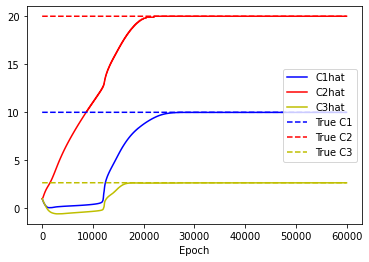

In [32]:
# reopen saved data using callbacks in fnamevar 
lines = open(fnamevar, "r").readlines()

# read output data in fnamevar (this line is a long story...)
Chat = np.array([np.fromstring(min(re.findall(re.escape('[')+"(.*?)"+re.escape(']'),line), key=len), sep=',') for line in lines])

l,c = Chat.shape

plt.plot(range(l),Chat[:,0],'b-')
plt.plot(range(l),Chat[:,1],'r-')
plt.plot(range(l),Chat[:,2],'y-')
plt.plot(range(l),np.ones(Chat[:,0].shape)*C1true,'b--')
plt.plot(range(l),np.ones(Chat[:,1].shape)*C2true,'r--')
plt.plot(range(l),np.ones(Chat[:,2].shape)*C3true,'y--')
plt.legend(['C1hat','C2hat','C3hat','True C1','True C2','True C3'],loc = "right")
plt.xlabel('Epoch')
plt.show()

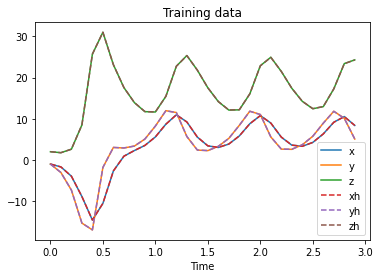

In [33]:
yhat = model.predict(observe_t)

plt.plot(observe_t, ob_y,'-',observe_t, yhat,'--')
plt.xlabel('Time')
plt.legend(['x','y','z','xh','yh','zh'])
plt.title('Training data')
plt.show()